# Как работать с данными в BigQuery с помощью Python

## Авторизация с помощью Google-аккаунта

Для подключения к BQ нужно установить модуль `pandas_gbq` [документация](https://pandas-gbq.readthedocs.io/en/latest/)

`pip install pandas_gbq`

In [1]:
# делаем импорт необходимых модулей

import pandas_gbq
import pydata_google_auth

In [2]:
# подключаем логгирование

import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

Чтобы при отображении прогресса запроса не приходили предупреждения, нужно поставить модуль `tqdm`.

`pip install tqdm`

In [3]:
# указываем к чему нам будет нужен доступ

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform'
]

In [4]:
# Получаем credentials

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

1. В открывшейся новой вкладке нужно выбрать рабочий аккаунт
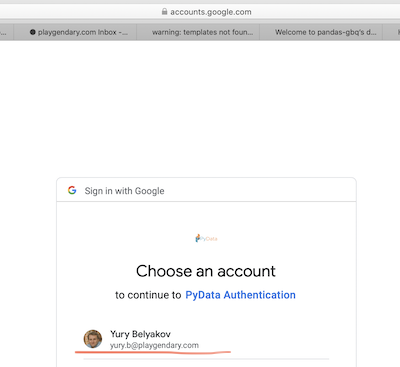

2. Затем разрешить доступ кнопкой **Allow**
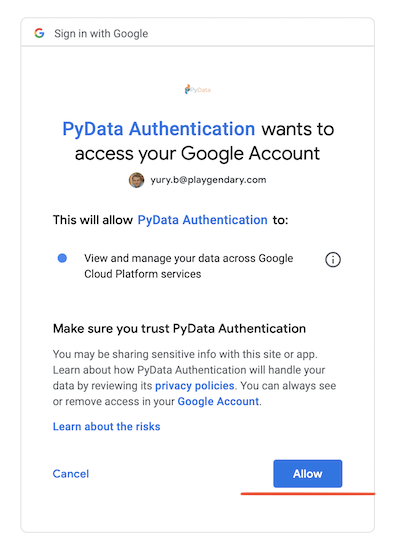

3. После этого откроется вкладка в браузере с текстом `The authentication flow has completed. You may close this window.` С этого момента можно работать с BQ из Python. 


## Примеры запросов

### SELECT

Наши данные лежат в BigQuery, которая имеет свои особенности. Разберем основные особенности, которые нужно знать на старте.

**В большинстве таблиц данные партицированы по дням, а также добавлена кластеризация.**

Существует два варианта партицирования:
- Партицирование с помощью так называемых Wildcard tables, подробнее можно посмотреть в [официальной документации](https://cloud.google.com/bigquery/docs/reference/standard-sql/wildcard-table-reference).
Возьмем для примера проект `playgendary-bi`. Сырые данные от Appsflyer лежат в датасете `appsflyer_datalocker_2`, все данные по установкам за один день лежат в таблице `installs_YYYYMMDD`. 

![data_scheme.png](0/data_scheme.png)


Ниже пример запроса, который берет данные по нескольким дням и считает количество новых пользователей за эти дни. Данные в `appsflyer_datalocker_2` хранятся только за последние 7 дней, поэтому даты в запросе нужно поменять на актуальные.

In [5]:
sql_select_installs = '''
SELECT
    PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS install_date,
    COUNT(1) AS installs
FROM
    `playgendary-bi.appsflyer_datalocker_2.installs_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20210805' AND '20210811'
    AND app_id = 'id1278869953'
GROUP BY
    install_date
ORDER BY
    install_date
'''

In [6]:
# отправляем запрос в BQ и получаем результат сразу в DataFrame.

df_installs = pandas_gbq.read_gbq(
    sql_select_installs,
    project_id='playgendary-bi',
    credentials=credentials
)

Requesting query... 
Query running...
Job ID: 1549c65c-e47d-4a38-bbcc-4d41686a0a5a
Query done.
Processed: 268.9 MB Billed: 269.0 MB
Standard price: $0.00 USD

Downloading: 100%|██████████| 7/7 [00:00<00:00, 62.79rows/s]
Got 7 rows.



In [7]:
# посмотрим на результат

df_installs

,install_date,installs
0,2021-08-05,52391
1,2021-08-06,52716
2,2021-08-07,60674
3,2021-08-08,63078
4,2021-08-09,53082
5,2021-08-10,47964
6,2021-08-11,44341


- Партицирование с помощью указания поля для партицирования (обычно дата), подробнее можно посмотреть в [официальной документации](https://cloud.google.com/bigquery/docs/partitioned-tables).

Также многие таблицы кластеризованы, подробнее можно посмотреть в [официальной документации](https://cloud.google.com/bigquery/docs/clustered-tables). Это значит, что данные в них лежат упорядоченно согласно кластерам, поэтому при выполнении запроса к таким таблицам с указанием условия в where для кластеризованного поля прочитается меньше данных.

![partitioning_and_clustering.png](0/partitioning_and_clustering.png)

**В BigQuery мы платим за количество прочитанных данных.**

В связи с этим нужно обязательно обращать внимание на количество данных, которые будут прочитаны. 
В web-интерфейсе до выполнения запроса приводится примерная оценка, сколько данных будет прочитано. 
В предварительной оценке учитывается партицирование, но не учитывается кластеризация. 
После выполения запроса будет указано, сколько реально данных было прочитано. 
Если выполнять запрос в python, то при включенном логировании также будет написано, сколько данных было прочитано и сколько это стоило.

![data_read.png](0/data_read.png)


**Еще одна особенность - вложенные поля:**

Это в основном касается данных Firebase, поэтому актуально для продуктовых аналитиков.

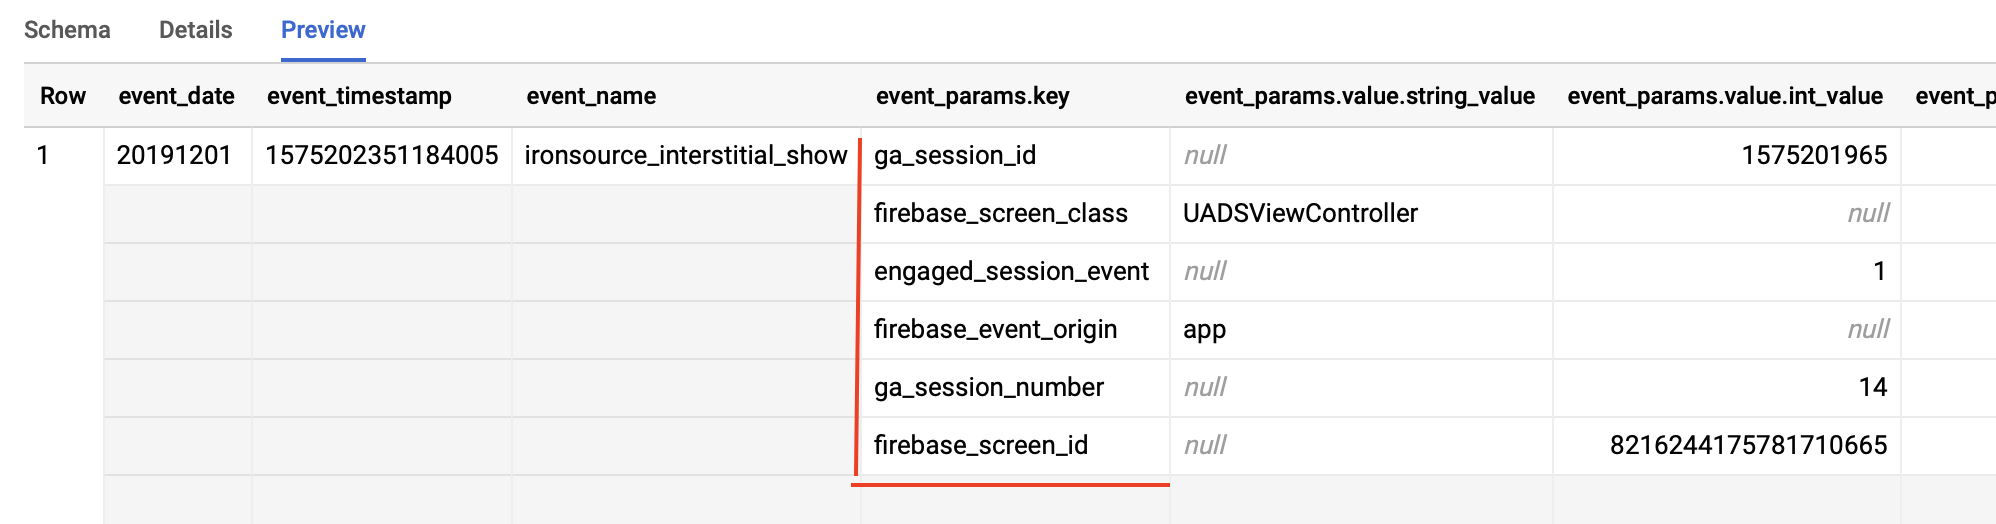

Чтобы работать с ними нужно использовать оператор `UNNEST`. Подробнее можно посмотреть в [документации](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#unnest).

Для примера посмотрим для одного пользователя список ивентов, отсортированных по времени, с `user_property`, отвечающим за сегментацию, и параметром `lvl_num`, отвечающим за уровень match-3.

NB: у аналитика не с проекта DM может не быть доступа в FiB, поэтому будет ошибка подключения

In [8]:
sql_unnest = '''
SELECT
    DATETIME(TIMESTAMP_MICROS(event_timestamp), 'Europe/Moscow') AS event_time,
    user_pseudo_id,
    user_id,
    event_name,
    (SELECT value.string_value FROM UNNEST(user_properties) AS event_params WHERE key = 'segmentation'
    ) AS segmentation,
    (SELECT value.string_value FROM UNNEST(event_params) AS event_params WHERE key = 'lvl_nm'
    ) AS lvl_nm
FROM
    `pg-homedesign-app.analytics_221981551.events_*`
WHERE
    _TABLE_SUFFIX = '20210706'
    AND user_id = '95e33ab0b685ca0fbd793d903db5c613c5a2c062'
ORDER BY
    user_pseudo_id, 
    event_time
'''

In [9]:
df_show_events = pandas_gbq.read_gbq(
    sql_unnest,
    project_id='pg-homedesign-app',
    credentials=credentials
)

Requesting query... 
Query running...
Job ID: 0a24915a-592b-4629-a051-71ede8035923
Query done.
Processed: 182.5 GB Billed: 182.5 GB
Standard price: $0.89 USD

Downloading: 100%|██████████| 82/82 [00:01<00:00, 74.52rows/s]
Got 82 rows.

Total time taken 6.14 s.
Finished at 2019-12-02 21:37:26.


In [10]:
df_show_events

,report_day,placement,user_count
77,2019-10-01,background_action,4372
55,2019-10-01,egg_first_purchase,24137
22,2019-10-01,free_spins_button,30471
76,2019-10-01,pinata_ads_purchase,37734
63,2019-10-01,pinata_first_purchase,498
...,...,...,...
56,2019-10-10,pinata_ads_purchase,35012
33,2019-10-10,pinata_first_purchase,392
67,2019-10-10,roulette_additional_card,208442
21,2019-10-10,ticket_red,530819


### CREATE

В некоторых случаях есть необходимость создать временную вспомогательную таблицу из подзапроса. Для этого в проекте `marketing-analytics-235713` есть раздел `temporary`. Общие рекомендации по неймингу новых таблиц в этом разделе: `фамилия_названиеТаблицы`. 

### Другие способы создания таблиц

#### Из CSV

[Loading CSV data from Cloud Storage](https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv)

#### Из DataFrame

С помощью команды `pandas_gbq.to_gbq(...)` можно записать имеющийся DataFrame в таблицу BigQuery, [документация](https://pandas-gbq.readthedocs.io/en/latest/writing.html)

### DROP

После использования таблицы ее можно удалить. Для этого нужно выполнить запрос `DROP TABLE temp_tables.tutor_dauKTB2` в [BigQuery Console](https://console.cloud.google.com/bigquery?_ga=2.252227850.-201355345.1570190141&pli=1&project=game-analytics-238110&folder&organizationId=270391287728&j=bq:EU:bquxjob_76368615_16ecc7c1049&page=queryresults)

Через `pandas_gbq` без ошибок такое выполнить нельзя.

## Авторизация через сервисный аккаунт

Если были выданы креды к сервисному аккаунту (`json` файл), то можно подключаться к BQ с помощью [google-cloud-bigquery](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python)

`pip install --upgrade google-cloud-bigquery`

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [4]:
# нужно вставить своей путь к файлу с кредами

credentials = service_account.Credentials.from_service_account_file('bq_credentials.json')
client = bigquery.Client('playgendary-bi', credentials)

In [5]:
query = '''
SELECT
  appId,
  eventName,
  SUM(eventCount) cnt,
  SUM(revenue) revenue
FROM
  `playgendary-bi.aggregated_data.daily_inapp_revenue`
WHERE
  installDate = '2021-07-20'
  AND appId IN ('id1495346254', 'com.playgendary.homes')
GROUP BY
  appId,
  eventName
'''

In [6]:
query_job = client.query(query)

In [7]:
df = query_job.result().to_dataframe()
df

,appId,eventName,cnt,revenue
0,id1495346254,com.playgendary.homes.iap.hard12,138,440.417543
1,id1495346254,com.playgendary.homes.iap.hard40,80,700.107266
2,id1495346254,com.playgendary.homes.iap.pack1,123,406.187169
3,id1495346254,com.playgendary.homes.iap.pack4,29,979.070274
4,com.playgendary.homes,com.playgendary.homes.iap.moneybox,54,257.022685
5,id1495346254,com.playgendary.homes.iap.pack2,114,773.528319
6,id1495346254,com.playgendary.homes.iap.moneybox,155,687.348898
7,id1495346254,com.playgendary.homes.iap.pack3,63,666.411969
8,com.playgendary.homes,com.playgendary.homes.iap.hard40,14,136.263016
9,com.playgendary.homes,com.playgendary.homes.iap.pack1,62,219.597506


Также у нас есть модуль [gap-filler](https://bitbucket.org/playgendary-dev/gap-filler/src/master/), в котором написан класс для работы с BQ через сервисный акканут.

`pip install git+ssh://git@bitbucket.org/playgendary-dev/gap-filler.git`

In [8]:
from gafill.data.connector import BiqQueryConnector
connector = BiqQueryConnector('playgendary-bi', 'bq_credentials.json')

In [9]:
df = connector.execute_df(query)
df

,appId,eventName,cnt,revenue
0,id1495346254,com.playgendary.homes.iap.hard12,138,440.417543
1,id1495346254,com.playgendary.homes.iap.hard40,80,700.107266
2,id1495346254,com.playgendary.homes.iap.pack1,123,406.187169
3,id1495346254,com.playgendary.homes.iap.pack4,29,979.070274
4,com.playgendary.homes,com.playgendary.homes.iap.moneybox,54,257.022685
5,id1495346254,com.playgendary.homes.iap.pack2,114,773.528319
6,id1495346254,com.playgendary.homes.iap.moneybox,155,687.348898
7,id1495346254,com.playgendary.homes.iap.pack3,63,666.411969
8,com.playgendary.homes,com.playgendary.homes.iap.hard40,14,136.263016
9,com.playgendary.homes,com.playgendary.homes.iap.pack1,62,219.597506
